## Importing Packages

In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor, ExactGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
# from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
from gpytorch.metrics import mean_standardized_log_loss, negative_log_predictive_density,  mean_squared_error
import time
import numpy as np
from utilities import plot,fits,gmm,errors,predict,preprocess

#### Latexifying Figures

In [4]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "Neurips/FinalPlots/"

## Data

In [5]:
def dataset_load(appliances, train, test=None, bias = False):
    x_train = []
    y_train = []
    train_time = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    app = 0

    ### train
    torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
            

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values

        timetrain = df["Timestamp"]
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(torch.tensor(x))
        y_train.extend(torch.tensor(y))
        x_train_timestamp.extend(torch.tensor(timestamp_train))
        train_time.extend(timetrain)

    x_train = torch.tensor(x_train).reshape(-1, 1)
    y_train = torch.tensor(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    ## test
    x_test = []
    test_time = []
    y_test = []
    x_test_timestamp = []
    app = 0
    for key, values in test.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
           
        timetest = df["Timestamp"]
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        
        if bias==True:
            x = x + 100*np.ones(x.shape[0])
        x_test.extend(torch.tensor(x))
        y_test.extend(torch.tensor(y))
        x_test_timestamp.extend(timestamp)
        test_time.extend(timetest)

    x_test = torch.tensor(x_test).reshape(-1, 1)
    y_test = torch.tensor(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1).to(torch.float32)
    y_train = torch.tensor(y_train).reshape(-1,).to(torch.float32)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1).to(torch.float32)
    x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1).to(torch.float32)
    y_test = torch.tensor(y_test).reshape(-1,).to(torch.float32)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float32)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time, test_time, train_time


In [6]:
train ={
    
    1:{
                    'start_time': "2011-04-28" ,
                    'end_time': "2011-05-15"
                },
        3: {
                'start_time': "2011-04-19" ,
                'end_time': "2011-05-22"
            }
                }
test = { 2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                }

appliances = ["Microwave", "Refrigerator",  "Dish Washer"] #

In [7]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time, test_time, train_time = dataset_load(appliances, train, test, bias=False)

/tmp/ipykernel_2482079/99696969.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).reshape(-1,).to(torch.float32)


In [17]:
x_train.shape, x_train_timestamp.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([24918, 1]),
 torch.Size([24918, 1]),
 torch.Size([15656, 1]),
 torch.Size([24918]),
 torch.Size([15656]))

In [18]:
x_train_full = x_train
y_train = y_train
x_test_full = x_test
x_train_full.shape, x_test_full.dtype

(torch.Size([24918, 1]), torch.float32)

## Extra

                           Train Mains
Time                                  
2011-04-28 00:00:00-04:00    10.750000
2011-04-28 00:01:00-04:00    10.812499
2011-04-28 00:02:00-04:00    10.874999
2011-04-28 00:03:00-04:00    10.812499
2011-04-28 00:04:00-04:00    10.750000


Text(0, 0.5, 'Power')

<Figure size 172.8x108 with 0 Axes>

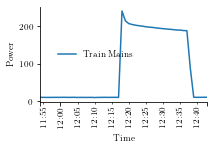

In [15]:
idx = 50 #x2.shape[0]
start = 4000

plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)

df = pd.read_csv("train_time.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Train Mains"] = scaler_x.inverse_transform(x_train)
# df["Ground Truth"] = yt.cpu()
# df["Prediction"] = y_mean_2
print(df.head())
df[start:start+idx].plot(rot=90)
sns.despine()
# df.plot.( rotation=90)
plt.legend(frameon=False, bbox_to_anchor=(0.6, 0.62))
# df.head()
# plt.ylim(0,350)
plt.ylabel("Power")
# savefig("kernel2_decomp_linear_withoutbias")
# plt.scatter(scaler_x.inverse_transform((x_train).reshape(-1,1)))

In [12]:
values = test_time
# startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
x_ticks_labels = pd.to_datetime(values)
x_ticks_labels
time_ = [(i.split('-04:00')[0].strip()) for i in test_time[:]]

date = [(i.split(' ')[0].strip()) for i in time_[:]]
mins_data = [(i.split(' ')[1].strip()) for i in time_[:]]
# print(time_)
# x_ticks_labels = mins_data

# ax.set_xticklabels(x_ticks_labels, rotation='vertical')

/tmp/ipykernel_2482079/3490323338.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels, rotation='vertical')


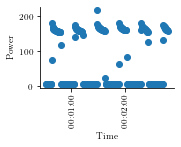

In [13]:
# plt.plot(scaler_x.inverse_transform((x_test).reshape(-1,1))[4000:4500])


# datetime.strptime(values["start_time"], "%Y-%m-%d").date()
# print(x_ticks_labels)
fig, ax = plt.subplots(1,1)
x_ticks_labels = mins_data


ax.scatter(x_test_timestamp[:300],y_test.reshape(-1,1)[:300] )

plt.xlabel("Time")
plt.ylabel("Power")
# plt.xticks(x_ticks_labels,   rotation='vertical')
ax.set_xticklabels(x_ticks_labels, rotation='vertical')
sns.despine()
plt.show()

## Needed

In [ ]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512



kernel1 = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=1, active_dims=(0))) #nu=2.5,ard_num_dims=1, active_dims=(0))
kernel2 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
kernel4 = ScaleKernel(MaternKernel(nu =0.5, ard_num_dims=1, active_dims=(1)))
# kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))
theta = { 
      'base_covar_module.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
#'base_covar_module.kernels.2.kernels.0.base_kernel.period_length': torch.tensor(0.01),
kernel5 = kernel2 + kernel4
kernel = kernel1 + kernel5
# induce_points = 512
inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],30)] #20
#x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")

# model = ExactGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel).to("cuda")
model = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel,
                     inducing_points).to("cuda")
# model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
# for param in model.parameters():
#   # print(param)
#   torch.nn.init.normal_(param, 0, 1)
# theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
#       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
#       'covar_module.outputscale': torch.tensor(5),}
loss = model.fit(lr=1e-3, n_epochs=3000,verbose=1,thetas=theta,
        random_state=0)
#   loss_arr.append(loss)
# print(loss)
plt.plot(np.asarray(loss[0]))
# plt.plot(np.asarray(test_loss[0]))


  

In [ ]:
model_name = "Point_to_point_main_power_and_time.pt"
torch.save(model.state_dict(), os.path.join(
  "Neurips/models", model_name))

In [19]:
kernel1 = ScaleKernel(MaternKernel(nu=2.5)) #nu=2.5,ard_num_dims=1, active_dims=(0))
kernel2 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
# kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
kernel4 = ScaleKernel(MaternKernel(nu =0.5, ard_num_dims=1, active_dims=(1)))
# kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))
theta = { 
      'base_covar_module.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
#'base_covar_module.kernels.2.kernels.0.base_kernel.period_length': torch.tensor(0.01),
# kernel5 = kernel2+ kernel4
kernel = kernel1 #+ kernel5
# induce_points = 512
inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],20)] #20
# # induce_points = 512
# inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],30)] 
# #x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")

model = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel,
                     inducing_points).to("cuda")

model_name = "Point_to_point_main_power.pt"
model.load_state_dict(torch.load(
    os.path.join("Neurips/models", model_name)))

<All keys matched successfully>

In [ ]:
# y_pred_arr =[]

# y_pred_arr.append(pred_dist.loc)

In [ ]:
# y_pred_arr1 = []
# for i in range(len(y_pred_arr)):
#   y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [ ]:
# import datetime
# time_ = [(i.split(' ')[1].strip()) for i in test_time[1:]]
# time_

## Extra

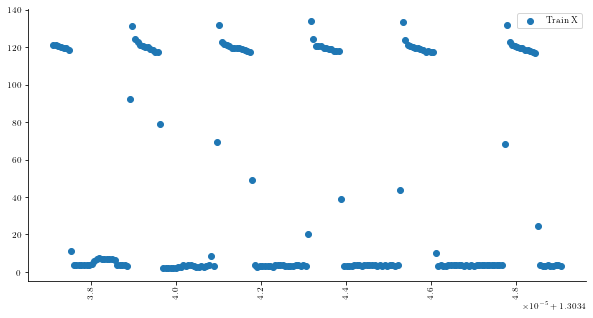

In [20]:
plt.figure(figsize=(10,5))
latexify(width_scale_factor=1.5, fig_height=2)
time_plot = scaler_time.inverse_transform(x_train_timestamp.cpu().reshape(-1,1))
# time_plot = np.array(time_)
idx = 200
start = 13000
# plt.plot(time_plot[start : start + idx], y_test.cpu()[start : start + idx], label = "Test Y")
plt.scatter(time_plot[start : start + idx],  scaler_x.inverse_transform(x_train.reshape(-1,1).cpu()).squeeze()[start : start + idx], label = "Train X")
# plt.scatter(time_plot[start : start + idx],  scaler_y.inverse_transform(y_train.reshape(-1,1).cpu()).squeeze()[start : start + idx], label = "Train Y")
sns.despine()
plt.xticks(rotation=90)
plt.legend()
# plt.show()
# savefig("Comparing_train_X_Y")

In [ ]:
# np.mean(scaler_x.inverse_t ransform(x_train.reshape(-1,1).cpu()).squeeze()), torch.mean(y_test)

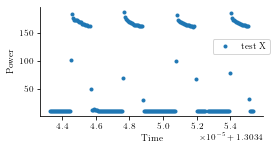

In [21]:
plt.figure()#figsize=(10,5)
latexify(width_scale_factor=3, fig_height=1.75)
time_plot = scaler_time.inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
# time_plot = np.array(time_)
idx = 200
start = 1300
plt.scatter(time_plot[start : start + idx],  scaler_x.inverse_transform(x_test.reshape(-1,1).cpu()).squeeze()[start : start + idx], label = "test X", s = 9)
# plt.scatter(time_plot[start : start + idx], y_test.cpu()[start : start + idx], label = "test Y")
plt.xlabel("Time")
plt.ylabel("Power")
sns.despine()
plt.xticks()
plt.legend( bbox_to_anchor=(1.05, 0.75))
# plt.show()
# savefig("test_X")

In [22]:
values = test_time
# startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
x_ticks_labels = pd.to_datetime(values)
x_ticks_labels
time_ = [(i.split('-04:00')[0].strip()) for i in test_time[:]]

date = [(i.split(' ')[0].strip()) for i in time_[:]]
mins_data = [(i.split(' ')[1].strip()) for i in time_[:]]
# print(mins_data[:300])
# x_ticks_labels = mins_data

# ax.set_xticklabels(x_ticks_labels, rotation='vertical')

saving image to Neurips/FinalPlots/kde_latexified.pdf
Figure size: [2.4  1.75]


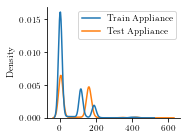

In [66]:
plt.figure()
latexify(width_scale_factor=2.5, fig_height=1.75)
sns.kdeplot(data = {"Train Appliance": scaler_y.inverse_transform(y_train.reshape(-1,1).cpu()).squeeze(),"Test Appliance": (y_test.cpu()).squeeze() })
sns.despine()
savefig("kde")

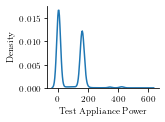

In [24]:
# plt.plot(time_plot1[start : start + idx], y_test.cpu()[start : start + idx], label = "Test Y")
plt.figure()#figsize=(10,5)
latexify(width_scale_factor=3, fig_height=1.5)
sns.kdeplot(data = {"Test Appliance Power": (y_test.cpu()).squeeze()}, x="Test Appliance Power")
sns.despine()
# savefig("kde_y_test")

In [25]:
max(scaler_x.inverse_transform(x_train.reshape(-1,1).cpu())), min(scaler_x.inverse_transform(x_train.reshape(-1,1).cpu())), max(scaler_x.inverse_transform(x_test.reshape(-1,1).cpu())), min(scaler_x.inverse_transform(x_test.reshape(-1,1).cpu()))

(array([2178.66668246]),
 array([1.12500142]),
 array([2087.37495506]),
 array([4.62500128]))

(array([1.7083e+04, 3.5400e+02, 4.9310e+03, 2.0050e+03, 3.3900e+02,
        1.6000e+01, 7.0000e+00, 3.6000e+01, 1.4500e+02, 2.0000e+00]),
 array([-4.44750654e-07,  4.97266666e+01,  9.94533337e+01,  1.49180001e+02,
         1.98906668e+02,  2.48633335e+02,  2.98360002e+02,  3.48086669e+02,
         3.97813336e+02,  4.47540003e+02,  4.97266670e+02]),
 <BarContainer object of 10 artists>)

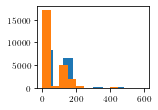

In [26]:
plt.hist(y_test.cpu())
plt.hist(scaler_y.inverse_transform(y_train.reshape(-1,1).cpu()).squeeze())

## Scatter plots

In [28]:
x_lin_max = 3000
x_lin = np.linspace(0,x_lin_max,15656) #+ 100*np.ones(np.array(x_test).shape[0])
x_time = np.linspace(scaler_time.inverse_transform(x_test_timestamp).min(), scaler_time.inverse_transform(x_test_timestamp).max(), 15656)
x_lin_scale = scaler_x.transform(x_lin.reshape(-1,1)).flatten() 
x_new =torch.tensor(x_lin_scale).reshape(-1,1).to(torch.float32)
# x_time_scale =  scaler_time.transform(x_time.reshape(-1,1)).flatten() 
# x_new = torch.cat((torch.tensor(x_lin_scale).reshape(-1,1).to(torch.float32), torch.tensor(x_time_scale).reshape(-1,1)),dim=1 ).to(torch.float32)
x_new.shape, x_new.dtype

(torch.Size([15656, 1]), torch.float32)

In [29]:
pred_dist = model.predict(x_new.to("cuda"))

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [30]:
y_mean = pred_dist.loc 
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1))

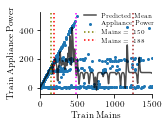

In [31]:
plt.figure()
latexify(width_scale_factor=2, fig_height=1.5)
start = 500
idx = 4000
plt.plot(x_lin, y_mean, 'k', label=" Predicted Mean", alpha=0.7)
plt.scatter( scaler_x.inverse_transform(x_train_full[:,0].reshape(-1,1)), scaler_y.inverse_transform(y_train.reshape(-1,1)), s = 4, label= "Appliance Power")
plt.xlim(00,1500)
sns.despine()
# plt.title("Train Mains Vs Train Applaince along with Predicted Means")

plt.xlabel("Train Mains")
plt.ylabel("Train Appliance Power")
# plt.show()
plt.axvline(x=145,color='olive', linestyle='dotted',label = "Mains = ~150")
plt.axvline(x=188,color='red', linestyle='dotted',label = "Mains = ~188")

plt.axvline(x=490,color='magenta', linestyle='dotted')
# # plt.axvline(x=430,color='red', linestyle='dotted',label = "Mains = ~188")
plt.axvline(x=1250,color='brown', linestyle='dotted')

plt.legend( frameon = False, fontsize = 6, bbox_to_anchor=(0.35, 0.55))
# savefig("Main_vs_app_mean")


## pred

In [35]:
pred_dist = model.predict((x_test_full).to("cuda"))

y_mean = pred_dist.loc 

In [36]:
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1).cpu()).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)

y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

torch.Size([15656]) (15656,)


In [37]:
# mae = np.mean(np.abs(np.array(y_test) - y_mean))
# rms = errors.rmse(jnp.array(y_test), y_mean)

# print("MAE: ", mae)
# print("RMSE: ", rms)

## MAE

In [38]:
mae = torch.abs(torch.tensor(y_mean) - y_test).mean(dim=-1)
mae

tensor(18.4366)

## MSLL

In [39]:
from math import pi

In [40]:
var_pred = pred_dist.variance
var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
# msll = mean_standardized_log_loss(torch.ensor(y_mean), y_test)
f_var= torch.tensor(var_pred)
f_mean = torch.tensor(y_mean)
msll = 0.5 * (torch.log(2 * pi * f_var) + torch.square(y_test - f_mean) / (2 * f_var)).mean(dim=-1)
msll

tensor(9.4116)

## NLPD

In [43]:
import math

In [48]:
def log_prob(y_pred, value):
        r"""
        See :py:meth:`torch.distributions.Distribution.log_prob
        <torch.distributions.distribution.Distribution.log_prob>`.
        """


        mean, covar = y_pred.loc.cpu(), y_pred.variance.cpu()
        diff = value - mean

        # Repeat the covar to match the batch shape of diff
        # if diff.shape[:-1] != covar.batch_shape:
        #     if len(diff.shape[:-1]) < len(covar.batch_shape):
        #         diff = diff.expand(covar.shape[:-1])
        #     else:
        #         padded_batch_shape = (*(1 for _ in range(diff.dim() + 1 - covar.dim())), *covar.batch_shape)
        #         covar = covar.repeat(
        #             *(diff_size // covar_size for diff_size, covar_size in zip(diff.shape[:-1], padded_batch_shape)),
        #             1,
        #             1,
        #         )

        # Get log determininant and first part of quadratic form
        covar = covar.evaluate_kernel()
        inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=diff.unsqueeze(-1), logdet=True)

        res = -0.5 * sum([inv_quad, logdet, diff.size(-1) * math.log(2 * math.pi)])
        return res

In [ ]:
log_prob(pred_dist,y_test)

In [ ]:
var_pred = pred_dist.variance
var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
# msll = mean_standardized_log_loss(torch.ensor(y_mean), y_test)
f_var= torch.tensor(var_pred)
f_mean = torch.tensor(y_mean)
nlpd = -pred_dist.log_prob(y_test) / y_test.shape[-1]

## QCE 95

In [41]:
quantile = 95.0
standard_normal = torch.distributions.Normal(loc=0.0, scale=1.0)
deviation = standard_normal.icdf(torch.as_tensor(0.5 + 0.5 * (quantile / 100)))
std_pred = pred_dist.stddev
std_pred = torch.tensor(scaler_y.inverse_transform(std_pred.reshape(-1,1).detach().cpu()).squeeze())
lower = torch.tensor(y_mean) - deviation * std_pred 
upper = torch.tensor(y_mean) + deviation * std_pred 
n_samples_within_bounds = ((y_test > lower) * (y_test < upper)).sum(-1)
fraction = n_samples_within_bounds / y_test.shape[-1]
qce = torch.abs(fraction - quantile / 100)
qce

tensor(0.0360)

## Var plot

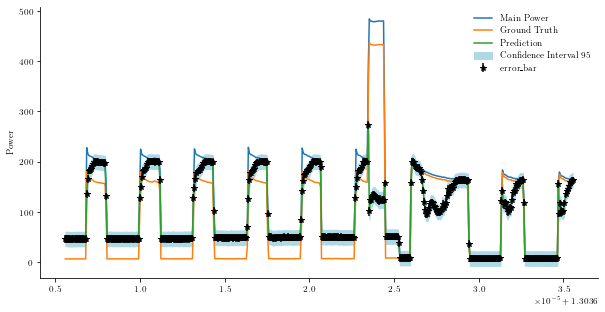

In [42]:
idx = 500
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
start = 4000
var_pred = pred_dist.variance
var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
time_plot = scaler_time.inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
# latexify(width_scale_factor=2, fig_height=1.75)
ax.plot(time_plot[start : start + idx], scaler_x.inverse_transform(x_test_full.cpu().reshape(-1,1))[start : start + idx], label = "Main Power")
ax.plot(time_plot[start : start + idx], y_test.cpu()[start : start + idx], label = "Ground Truth")
ax.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
ax.fill_between(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten() - 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  y_mean[start : start + idx].flatten() + 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  color='lightblue', alpha=1.0, label = "Confidence Interval 95%)")
ax.errorbar(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten(), yerr=np.sqrt(var_pred[start : start + idx]).flatten(), fmt='k*', label = "error_bar")
plt.legend(frameon=False)
ax.set_ylabel("Power" )
sns.despine()
# plt.show()


## Plots

In [43]:
values = test_time
# startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
x_ticks_labels = pd.to_datetime(values)
x_ticks_labels
time_ = [(i.split('-04:00')[0].strip()) for i in test_time[:]]

date = [(i.split(' ')[0].strip()) for i in time_[:]]
mins_data = [(i.split(' ')[1].strip()) for i in time_[:]]
secs = [(i.split(':00')[1].strip()) for i in time_[:]]
# hrs = [(i.split(':00')[].strip()) for i in mins_data[:]]
# print(time_)
# x_ticks_labels = mins_data

# ax.set_xticklabels(x_ticks_labels, rotation='vertical')

def date_con(input_string:str):
  year,month,day = input_string.split("-")
  ret_month = ''
  if(int(month)==4):
    ret_month = 'April'
  elif(int(month)==5):
    ret_month  = 'May'
  
  ret_string  = f"{day} {ret_month}"
  return ret_string
  

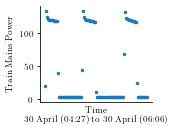

In [45]:

idx = 100
fig, ax = plt.subplots(1,1) 
start = 13100
#figsize=(10,5)
time_plot = scaler_time.inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
latexify(width_scale_factor=3, fig_height=1.75)
ax.scatter(time_plot[start : start + idx], scaler_x.inverse_transform(x_train)[start : start + idx], label = "Train Main", s = 6)
# ax.plot(time_plot[start : start + idx], y_test.cpu()[start : start + idx], label = "Ground Truth")
# ax.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
# plt.legend(frameon=False, bbox_to_anchor=(0.6, 1.05))
mins = mins_data[start : start + idx]
dates = date[start : start + idx]
ax.set_ylabel("Train Mains Power" )
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
)
ax.set_xlabel("Time" + "\n" + date_con(dates[0]) +" (" + mins[0][:-3]+ ") " + "to  " + date_con(dates[-1])+ " (" + mins[-1][:-3]+ ")")
# ax.xaxis.set_label_coords(.9, -.1)
sns.despine()
# plt.show()
# savefig("Train_Scatter")

saving image to Neurips/FinalPlots/Point_to_point_plt2_latexified.pdf
Figure size: [3.   1.75]


<Figure size 216x126 with 0 Axes>

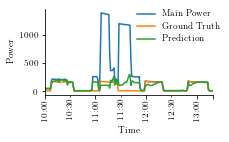

In [66]:
idx = 200 #x2.shape[0]
start = 4800

plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)
df = pd.read_csv("time_stamp.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Main Power"] = scaler_x.inverse_transform(x_test_full.cpu().reshape(-1,1) )
df["Ground Truth"] = y_test.cpu()
df["Prediction"] = y_mean
df[start:start+idx].plot(rot=90)
sns.despine()
# df.plot.( rotation=90)
plt.legend(frameon=False, bbox_to_anchor=(0.5, 0.5))
# df.head()
# plt.ylim(0,350)
plt.ylabel("Power")
savefig("Point_to_point_plt2")

saving image to Neurips/FinalPlots/Point_to_point_bias100_plt_latexified.pdf
Figure size: [3.   1.75]


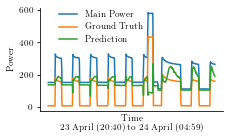

In [19]:
idx = 500
fig, ax = plt.subplots(1,1) 
start = 4000
#figsize=(10,5)
time_plot = scaler_time.inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
latexify(width_scale_factor=2, fig_height=1.75)
ax.plot(time_plot[start : start + idx], scaler_x.inverse_transform(x_test_full.cpu().reshape(-1,1) ), label = "Main Power")
ax.plot(time_plot[start : start + idx], y_test.cpu()[start : start + idx], label = "Ground Truth")
ax.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
plt.legend(frameon=False, bbox_to_anchor=(0.6, 1.05))
mins = mins_data[start : start + idx]
dates = date[start : start + idx]
ax.set_ylabel("Power" )
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
)
ax.set_xlabel("Time" + "\n" + date_con(dates[0]) +" (" + mins[0][:-3]+ ") " + "to  " + date_con(dates[-1])+ " (" + mins[-1][:-3]+ ")")
# ax.xaxis.set_label_coords(.9, -.1)
sns.despine()
# plt.show()
savefig("Point_to_point_bias100_plt")

In [ ]:
for name, params in model.named_parameters():
  print(name, params)

In [ ]:
model.mll.model.base_covar_module.outputscale

In [ ]:
model.mll.model.mean_module.constant

## Decomposition

In [ ]:
model1 = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [ ]:
pred_dist1 = model1.predict(x_test_full[12000:14000].to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [ ]:
y_pred_arr =[]

y_pred_arr.append(pred_dist1.loc)

In [ ]:
y_mean1.shape

In [ ]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [ ]:
y_mean1 = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr1, axis=0)

y_mean1.shape#, y_sigma.shape

y_mean1 = scaler_y.inverse_transform(y_mean1.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean1.shape)

# y_mean1 = np.clip(y_mean1,0,y_mean1.max(),out=y_mean1)

In [ ]:
mae = np.mean(np.abs(np.array(y_test[:2000]) - y_mean1))
rms = errors.rmse(jnp.array(y_test[:2000]), y_mean1)

print("MAE: ", mae)
print("RMSE: ", rms)

In [ ]:
np.array(y_mean1)

In [ ]:
idx = 300
start = 12000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[start:start+idx], y_test.cpu()[start:start+idx], label = "Refri")
idx1 = 300
start1 = 1000
plt.plot(x_test_timestamp[start:start+idx], y_mean1[start1:start1+idx1], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

In [ ]:
model2 = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel5,
                      inducing_points).to("cuda")

In [ ]:
pred_dist2 = model2.predict(x_test_full[12000:14000].to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

In [ ]:
y_pred_arr =[]

y_pred_arr.append(pred_dist2.loc)

In [ ]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [ ]:
y_mean2 = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr2, axis=0)

y_mean2.shape#, y_sigma.shape

y_mean2 = scaler_y.inverse_transform(y_mean2.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean2.shape)

y_mean2 = np.clip(y_mean2,0,y_mean2.max(),out=y_mean2)

In [ ]:
mae = np.mean(np.abs(np.array(y_test[:4000]) - y_mean2))
rms = errors.rmse(jnp.array(y_test[:4000]), y_mean2)

print("MAE: ", mae)
print("RMSE: ", rms)

In [ ]:
idx = 300
start  = 13000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[start : start + idx], y_test.cpu()[start : start + idx], label = "Refri")
idx1 = 300
start1  = 1000
plt.plot(x_test_timestamp[start : start + idx], y_mean2[start1 : start1 + idx1], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()